## Importing libraries

In [1]:
!pip install torch torchmetrics torchaudio datasets transformers scikit-learn matplotlib wandb torchcodec

from datasets import load_dataset
from transformers import (
    AutoFeatureExtractor,
    AutoModelForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import librosa
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from google.colab import drive
import os
from google.colab import userdata
import torch
import wandb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.9 MB/s eta 0:00:00


## Getting paths for metadata and getting a key for wandb

In [2]:
BASE_DIR = '/content/'

TRAIN_PATH = os.path.join(BASE_DIR, 'train.csv')
VALID_PATH = os.path.join(BASE_DIR, 'valid.csv')
TEST_PATH  = os.path.join(BASE_DIR, 'test.csv')

wandb_kay = userdata.get('WANDB')

## Log in to wandb

In [3]:
wandb.login(key=wandb_kay)

wandb.init(
    project="AST",
)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: boklahbohdan (detect_kaggle) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Cloning your google drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Selecting the target directory

In [5]:
!rsync -a "/content/drive/MyDrive/audio_cls/" .

## Downloading a dataset

In [6]:
dataset = load_dataset(
    "csv",
    data_files={
        "train": TRAIN_PATH,
        "valid": VALID_PATH,
        "test" : TEST_PATH
    }
)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['path', 'target'],
        num_rows: 480
    })
    valid: Dataset({
        features: ['path', 'target'],
        num_rows: 96
    })
    test: Dataset({
        features: ['path', 'target'],
        num_rows: 105
    })
})

## Fix paths for a google colab

In [7]:
DATA_DIR_TRAIN = "/content/train"
DATA_DIR_VALID = "/content/valid"
DATA_DIR_TEST  = "/content/test"

def fix_path_train(example):
    example["path"] = f"{DATA_DIR_TRAIN}/{example["path"]}"
    return example

def fix_path_valid(example):
    example["path"] = f"{DATA_DIR_VALID}/{example["path"]}"
    return example

def fix_path_test(example):
    example["path"] = f"{DATA_DIR_TEST}/{example["path"]}"
    return example

def fix_label(example):
    example["labels"] = example.pop("target")
    return example

train_df = dataset['train']
valid_df = dataset['valid']
test_df  = dataset['test']

train_df = train_df.map(fix_path_train)
valid_df = valid_df.map(fix_path_valid)
test_df  = test_df.map(fix_path_test)

train_df = train_df.map(fix_label)
valid_df = valid_df.map(fix_label)
test_df  = test_df.map(fix_label)


Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

## Initial model

In [8]:
MODEL_NAME = "MIT/ast-finetuned-audioset-10-10-0.4593"
NUM_LABELS = 4

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
model = AutoModelForAudioClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Downloading audio samples

In [9]:
def preprocess(batch):
    waveform, sr = librosa.load(batch["path"], sr=16000)
    inputs = feature_extractor(
        waveform,
        sampling_rate=16000,
        return_tensors="pt"
    )
    batch["input_values"] = inputs["input_values"].squeeze(0).tolist()
    return batch

train_df = train_df.map(preprocess)
valid_df = valid_df.map(preprocess)
test_df  = test_df.map(preprocess)

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

## Implement metrics computing

In [10]:
def compute_metrics_hf(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    labels = torch.tensor(labels).long()
    probs = torch.nn.functional.softmax(logits, dim=-1)
    preds = probs.argmax(dim=-1)
    labels_np = labels.cpu().numpy()
    preds_np = preds.cpu().numpy()
    return {
        "accuracy": accuracy_score(labels_np, preds_np),
        "f1_macro": f1_score(labels_np, preds_np, average="macro"),
        "precision_macro": precision_score(labels_np, preds_np, average="macro"),
        "recall_macro": recall_score(labels_np, preds_np, average="macro"),
    }

## Implement a data collator

In [11]:
def collate_fn(features):
    xs = torch.stack(
        [torch.tensor(f["input_values"], dtype=torch.float32) for f in features]
    )
    labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)
    return {"input_values": xs, "labels": labels}

## Initial a training config

In [12]:
train_batch_size = 48
val_batch_size = 24
EPOCHS = 200

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.0
)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=val_batch_size,
    num_train_epochs=EPOCHS,
    eval_strategy="steps",
    save_steps=10,
    eval_steps=10,
    logging_strategy="steps",
    logging_steps=10,
    report_to="wandb",
    fp16=False,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=valid_df,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics_hf,
    data_collator=collate_fn,
    callbacks=[early_stopping]
)

/tmp/ipython-input-900055848.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training a model

In [13]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
10,0.578900,0.071557,0.989583,0.991831,0.992857,0.991071
20,0.089300,0.025872,0.989583,0.991883,0.991379,0.992647
30,0.026800,0.026247,0.989583,0.988698,0.986842,0.991071
40,0.029800,0.002282,1.000000,1.000000,1.000000,1.000000
50,0.007000,0.001099,1.000000,1.000000,1.000000,1.000000
60,0.012500,0.001337,1.000000,1.000000,1.000000,1.000000
70,0.001300,0.000220,1.000000,1.000000,1.000000,1.000000
80,0.002700,0.000149,1.000000,1.000000,1.000000,1.000000
90,0.014900,0.000147,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=90, training_loss=0.0847849011524684, metrics={'train_runtime': 2211.1338, 'train_samples_per_second': 43.417, 'train_steps_per_second': 0.905, 'total_flos': 2.9282709352218624e+17, 'train_loss': 0.0847849011524684, 'epoch': 9.0})

## Saving artifacts to wandb

In [14]:
trainer.save_model("./results/best_model")
feature_extractor.save_pretrained("./results/best_model")
artifact = wandb.Artifact("best_model", type="model")
artifact.add_dir("./results/best_model")
wandb.log_artifact(artifact)

wandb: Adding directory to artifact (results/best_model)... Done. 10.5s


<Artifact best_model>

## Calculating metrics

In [15]:
predictions_output = trainer.predict(test_df)
print("Метрики на тесті:")
for k, v in predictions_output.metrics.items():
    print(f"{k}: {v:.4f}")
logits = predictions_output.predictions
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)
preds = probs.argmax(dim=-1).numpy()
labels = predictions_output.label_ids

Метрики на тесті:
test_loss: 0.1281
test_accuracy: 0.9524
test_f1_macro: 0.9496
test_precision_macro: 0.9632
test_recall_macro: 0.9423
test_runtime: 16.6532
test_samples_per_second: 6.3050
test_steps_per_second: 0.3000


In [16]:
wrong_idx = np.where(preds != labels)[0]

print(f"Кількість помилок: {len(wrong_idx)}")
print("Перші 10 помилкових прикладів:")
for i in wrong_idx[:10]:
    print(f"Index {i}: true={labels[i]}, pred={preds[i]}, probs={probs[i].tolist()}")

Кількість помилок: 5
Перші 10 помилкових прикладів:
Index 60: true=2, pred=3, probs=[0.0024762549437582493, 0.0003032124077435583, 0.29313117265701294, 0.704089343547821]
Index 68: true=1, pred=3, probs=[0.013282549567520618, 0.35360631346702576, 0.00100059958640486, 0.6321105360984802]
Index 77: true=1, pred=3, probs=[0.00011308042303426191, 0.001912597450427711, 0.0006215314497239888, 0.9973528385162354]
Index 81: true=1, pred=3, probs=[0.00033352288301102817, 0.32563504576683044, 0.002931240713223815, 0.6711001992225647]
Index 90: true=0, pred=3, probs=[0.0895913615822792, 0.00028442192706279457, 0.00023305318609345704, 0.9098911881446838]


## Make confusion matrix

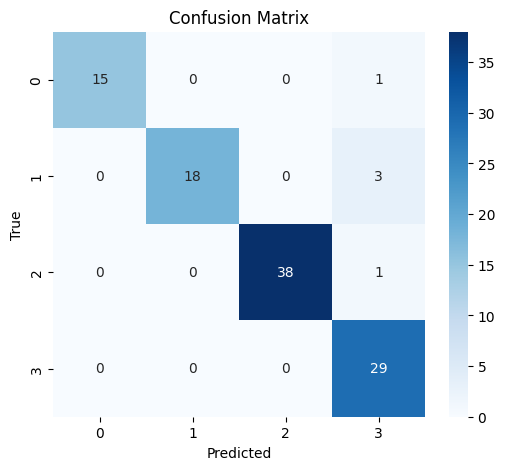

In [17]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()